头定义，部分运行使用

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
k=2
m=5
n=4
relu=torch.relu
trial_count=3
iter_count=10

# 神经层分析

**Linear**
定义网络层（线性层）
层输入：$\mathbf{x}\sim tensor(k,m)$
层权值：$\mathbf{w}\sim (n,m)$
层偏移：$\mathbf{b}\sim (n)$
层激活：$\mathbf{f}(\mathbf{x})$
层输出：$\mathbf{y}\sim (k,n)$
计算：$$
\mathbf{z}=\mathbf{x}\cdot\mathbf{w}^T+\mathbf{b}\\
\mathbf{y}=\mathbf{f}(\mathbf{z})
$$


去点积化：$$
\mathbf{xx} = \mathbf{x}.as(k,1,m)\\
\mathbf{z} = (\mathbf{xx}*\mathbf{w}).rsum(2) + \mathbf{b} \sim (k,n)\\
\mathbf{y} = \mathbf{f}(\mathbf{z})
$$

理论计算与编程计算的对应
\begin{matrix}计算|领域&\mathbf{math}&\mathbf{pytorch}\\
变形&x.as(a,b)&x.reshape(a,b)\\
重复&x.repeat(a,b)&x.repeat(a,b)\\
加法&sum(x,dim)&sum(x,dim,True)\\
消除加法&rsum(x,dim)=sum(x,dim).transpose(...dim-1,dim+1...)&sum(x,dim)\end{matrix}

**FP的计算过程**
点积法

In [4]:
k=2
m=5
n=4
x=torch.rand(k,m)
w=torch.rand(n,m)
b=torch.rand(n)
# f is None
z=torch.mm(x,w.T)+b
y=z
y.shape

torch.Size([2, 4])

非点积法

In [5]:
xx=x.reshape(k,1,m)
z=(xx*w).sum(2,False)+b
y=z
y.shape

torch.Size([2, 4])

计算分解：
**FP前向传播**
$$
xt=x.as(k,1,m)\\
xtp=xt.repeat(1,n,1)\sim(k,n,m)\\
wp=w.repeat(k,1,1)\\
zp=xtp*wp\sim(k,n,m)\\
zs=zp.sum(2)\sim(k,n,1)\\
zsr=zs.as(k,n)\\
bt=b.as(1,n)\\
btp=bt.repeat(k,1)\sim(k,n)\\
zb=zsr+btp\\
y=f(zb)
$$

**梯度计算法则**
变形
$$\mathbf{x}\sim(a,b)\\
\mathbf{or}\ \mathbf{x}\sim(shape\_sequence\_x)\\
a*b=c*d\\
\mathbf{or}\ (shape\_sequence\_x).product=(shape\_sequence\_y).product\\
\mathbf{y}=\mathbf{x}.as(c,d)\\
y\sim(c,d)$$
定义抽象目标函数
$$O(\mathbf{x})\\
\begin{align}
\frac{\partial O}{\partial x}&=\frac{dO}{dy}|_{\{c,d\}}\cdot\frac{dy}{dx}|_{\{c,d|a,b\}}\\
&=\frac{dO}{dy}.reshape(shape\_sequence\_x)
\end{align}
$$

上式显然，下面增加详细推导
引用平铺函数
$$
y=flatten(x) = x.as(a*b)\\
y[i*a+j]=x[i,j]
$$
等效线性变换
$$
w[i,j,k]=
\left\{\begin{matrix}
1,i=j*a+k\\
0,else
\end{matrix}\right.\\
y=(w*x).rsum(1,2)\sim(a,b)\rightarrow (1)
$$
其导数为$$
\begin{align}
\frac{dy}{dx}[i,j,k]&=
\left\{\begin{matrix}
1,i=j*a+k\\
0,else
\end{matrix}\right.\\
\frac{dy}{dx}&=w
\end{align}\\
\frac{dO}{dy}\sim(a*b)\\
\begin{align}
\frac{dO}{dx}&=&\frac{dO}{dy}\cdot w&=& \left((\frac{dO}{dy}).as(a*b,1,1)*w\right).rsum(0)\\
&& &=&\left(w.transpose(1,2,0)*\frac{dO}{dy}\right).rsum(2)\leftarrow (1)\\
&=& (\frac{dO}{dy}).as(a,b) &&
\end{align}
$$

In [6]:
x=torch.rand(3,4)
y=x.reshape(2,6)
yg=torch.rand(2,6)
xg=yg.reshape(3,4)

重复
$$
x\sim(a,1)\\
y=x.repeat(1,b)\\
\frac{dO}{dx}=\frac{dO}{dy}.sum(1)
$$
重复对应求和

In [7]:
x=torch.rand(3,1)
y=x.repeat(1,4)
yg=torch.rand(3,4)
xg=yg.sum(1,True)

乘法
$$
x\sim(a,b)\\
w\sim(a,b)\\
y=x*w\\
\frac{dO}{dx}=\frac{dO}{dy}*w\\
xg=yg*w\\
wg=yg*x
$$

In [8]:
x=torch.rand(3,4)
w=torch.rand(3,4)
y=x*w
yg=torch.rand(3,4)
xg=yg*w
wg=yg*x

求和
$$
x\sim(a,b)\\
y=x.sum(1)\\
xg=yg.repeat(1,b)
$$

In [9]:
x=torch.rand(3,4)
y=x.sum(1,True)
yg=torch.rand(3,1)
xg=yg.repeat(1,4)

加法
$$
x\sim(a,b)\\
w\sim(a,b)\\
y=x+w\\
\frac{dO}{dx}=\frac{dO}{dy}*w\\
xg=wg=yg
$$

In [10]:
x=torch.rand(3,4)
w=torch.rand(3,4)
y=x+w
yg=torch.rand(3,4)
xg=wg=yg

广播函数
如果函数结果的每个元素仅为一元函数施加在对应元素上
$$\mathbf{f}(\mathbf{x})
=\begin{bmatrix}
f_1(\mathbf{x})\\
f_2(\mathbf{x})\\
\vdots
\end{bmatrix}
===\begin{bmatrix}
f_1(x_1)\\
f_1(x_2)\\
\vdots
\end{bmatrix}
$$
其梯度为
$$
\frac{\partial f}{\partial x}=diag(\cdots,\frac{\partial f}{\partial x_i},\cdots)
$$


BP计算**gradient**.....
$$
zbg=yg\cdot\frac{dy}{dzb}\sim(k,n)\\
relu:zbg=yg*(zb>0)\\
zsrg=btpg=zbg\\
btg=btpg.sum(0)\\
bg=btg.as(n)\\
zsg=zsrg.as(k,n,1)\\
zpg=zsg.repeat(1,1,m)\sim(k,n,m)\\
wpg=zpg*xtp\sim(k,n,m)\\
wg=wpg.rsum(0)\\
xtpg=zpg*wp
xtg=xtpg.sum(1)\sim(k,1,m)\\
xg=xtg.as(k,m)
$$

In [47]:
class Linear:
    def __init__(self,input_shape,output_shape,activation=None):
        self.input_shape=input_shape
        self.output_shape = output_shape
        self.w=torch.randn(output_shape,input_shape)
        self.b=torch.randn(output_shape)
        self.f=None
        self.activation=activation
        if activation=='relu':
            self.f=relu
    def __call__(self,x):
        k,m=x.shape
        assert m==self.input_shape
        n=self.output_shape
        self.x=x
        self.xt=self.x.reshape(k,1,m)
        self.xtp=self.xt.repeat(1,n,1)
        self.wp=self.w.repeat(k,1,1)
        self.zp=self.xtp*self.wp
        self.zs=self.zp.sum(2,False)
        self.zsr=self.zs.reshape(k,n)
        self.bt=self.b.reshape(1,n)
        self.btp=self.bt.repeat(k,1)
        self.zb=self.zsr+self.btp
        if self.f:
            y=self.f(self.zb)
        else:
            y=z
        return y
    def update(self,yg,rate):
        if self.activation=='relu':
            zbg=yg*(self.zb>0)
        elif self.activation==None:
            zbg=yg
        else:
            raise Exception('activation not available!')
        zsrg=btpg=zbg
        btg=btpg.sum(0,True)
        bg=btg.reshape(n)
        zsg=zsrg.reshape(k,n,1)
        zpg=zsg.repeat(1,1,m)
        xtpg=wpg=zpg
        wg=wpg.sum(0,False)
        xtg=xtpg.sum(1,True)
        xg=xtg.reshape(k,m)
        self.w-=rate*wg
        self.b-=rate*bg
x=torch.rand(k,m)
layer = Linear(m,n,'relu')
layer(x)

tensor([[3.2198, 0.8234, 1.1758, 0.0000],
        [4.7900, 0.0000, 1.2523, 0.0000]])

tensor([[2.3315, 2.1818, 2.0322, 1.8825, 1.7328, 1.5832, 1.4335, 1.2838, 1.1342,
         0.9845],
        [6.5189, 6.2062, 5.8934, 5.6140, 5.4165, 5.2190, 5.0215, 4.8240, 4.6265,
         4.4290],
        [6.5348, 6.1885, 5.8422, 5.4959, 5.1496, 4.8314, 4.5973, 4.3632, 4.1291,
         3.8950]])


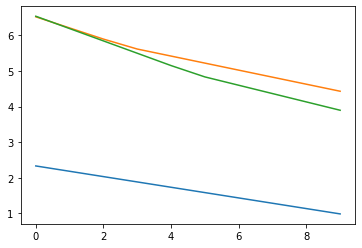

In [49]:
trial_count=3
iter_count=10
O_descending=torch.zeros(trial_count,iter_count)
O_fun=lambda x:layer(x).sum()
for i in range(trial_count):
    x=torch.rand(k,m)
    layer = Linear(m,n,'relu')
    O_descending[i,0]=O_fun(x)
    for j in range(1,iter_count):
        yg=torch.ones(k,n)
        layer.update(yg,0.01)
        O_descending[i,j]=O_fun(x)
print(O_descending)
plt.plot(O_descending.T)

化简
FP
$$
z=(x.reshape(k,n,1)*w).sum(2)+b\\
y=f(z)
$$
BP
$$
wg=(zg.as(k,n,1).repeat(1,1,m)*x.as(k,1,m).repeat(1,n,1)).rsum(0)\\
=(zg.as(k,n,1)*x.as(k,1,m)).rsum(0)\\
bg=zg.rsum(0)\\
xg=(zg.as(k,n,1).repeat(1,1,m)*w.repeat(k,1,1)).sum(1).as(k,m)\\
=(zg.as(k,n,1)*w).rsum(1)
$$

tensor([[4.7417, 4.6221, 4.5024, 4.3828, 4.2631, 4.1435, 4.0239, 3.9042, 3.7846,
         3.6649],
        [7.1046, 6.9604, 6.8161, 6.6719, 6.5276, 6.3834, 6.2391, 6.0949, 5.9506,
         5.8064],
        [3.9538, 3.7282, 3.5027, 3.2772, 3.0517, 2.8262, 2.6328, 2.4938, 2.3547,
         2.2157]])


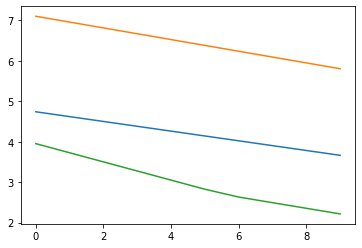

In [14]:
class Linear:
    def __init__(self,input_shape,output_shape,activation=None):
        self.input_shape=input_shape
        self.output_shape = output_shape
        self.w=torch.randn(output_shape,input_shape)
        self.b=torch.randn(output_shape)
        self.f=None
        self.activation=activation
        if activation=='relu':
            self.f=relu
    def __call__(self,x):
        k,m=x.shape
        assert m==self.input_shape
        n=self.output_shape
        self.x=x
        self.z=(self.x.reshape(k,1,m)*self.w).sum(2)+self.b
        if self.f:
            y=self.f(self.z)
        else:
            y=z
        return y
    def update(self,yg,rate):
        if self.activation=='relu':
            zbg=yg*(self.z>0)
        elif self.activation==None:
            zbg=yg
        else:
            raise Exception('activation not available!')
        wg=(zbg.reshape(k,n,1)*self.x.reshape(k,1,m)).sum(0)
        bg=zbg.sum(0)
        xg=(zbg.reshape(k,n,1)*self.w).sum(1)
        self.w-=rate*wg
        self.b-=rate*bg
trial_count=3
iter_count=10
O_descending=torch.zeros(trial_count,iter_count)
O_fun=lambda x:layer(x).sum()
for i in range(trial_count):
    x=torch.rand(k,m)
    layer = Linear(m,n,'relu')
    O_descending[i,0]=O_fun(x)
    for j in range(1,iter_count):
        yg=torch.ones(k,n)
        layer.update(yg,0.01)
        O_descending[i,j]=O_fun(x)
print(O_descending)
plt.plot(O_descending.T)

# 附录
草稿

计算偏导：$$
\frac{\partial O}{\partial y}\sim(k,n)\\
\frac{dO}{dz}=\frac{dO}{dy}\cdot\frac{dy}{dz}\sim(k,n)\\
\frac{dO}{dxx}=\frac{dO}{dz}\cdot\frac{dz}{dxx}\\
=\left (\frac{dO}{dz}_{\{k,n\}}.as(k,n,1).repeat(1,1,m)*w.as(1,n,m)\right )_{\{k,n,m\}}.sum(1)\sim(k,1,m)\\
\frac{dO}{dx}=\frac{dO}{dxx}.as(k,m)\\
\frac{dO}{dw}=\left (\frac{dO}{dz}.as(k,n,1).repeat(1,1,m)*xx\right)_{\{k,n,m\}}.rsum(0)\\
\frac{dO}{db}=\frac{dO}{dz}.sum(0)
$$

In [21]:
dody=torch.rand(k,n)
dodz=dody
dodxx=(dodz.reshape(k,n,1).repeat(1,1,m)*w.reshape(1,n,m)).sum(1)
dodx=dodxx.reshape(k,m)
print(dodx.shape)
dodw=(dodz.reshape(k,n,1).repeat(1,1,m)*xx).sum(0)
print(dodw.shape)

torch.Size([2, 5])
torch.Size([4, 5])


$$
xg=(zg.as(k,n,1)*w).rsum(1)\\
wg=(zg.as(k,n,1)*x.as(k,1,m)).rsum(0)
$$

In [26]:
zg=torch.rand(k,n)
xg=(zg.reshape(k,n,1)*w).sum(1)
print(xg.shape)
wg=(zg.reshape(k,n,1)*x.reshape(k,1,m)).sum(0)
print(wg.shape)
bg=zg.sum(0)
print(bg.shape)

torch.Size([2, 5])
torch.Size([4, 5])
torch.Size([4])


In [31]:
relu=torch.relu
class Linear:
    def __init__(self,input_shape,output_shape,activation=None):
        self.w=torch.randn(output_shape,input_shape)
        self.b=torch.randn(output_shape)
        self.f=None
        if activation=='relu':
            self.f=relu
    def __call__(self,x):
        self.x=x
        xx=x.reshape(k,1,m)
        z=(xx*self.w).sum(2)+self.b
        if self.f:
            y=self.f(z)
        else:
            y=z
        return y
    def update(self,yg,rate):
        xx=self.x.reshape(k,1,m)
        z=(xx*self.w).sum(2)+self.b
        zg=yg*(z>0)
        wg=(zg.reshape(k,n,1)*x.reshape(k,1,m)).sum(0)
        bg=zg.sum(0)
        self.w-=rate*wg
        self.b-=rate*bg
layer = Linear(m,n,'relu')
layer(x)

tensor([[1.1406, 1.3594, 0.0000, 0.0000],
        [0.0000, 1.9571, 0.0000, 0.0000]])

Objective:
$$
O=sum(y)\\
f=relu\\
\frac{dO}{dy}=ones\_like(y)\\
\frac{dO}{dz}=ones(k,n)*(z>0)=1.0*(z>0)\\
\frac{dO}{dz}=\frac{dO}{dy}=ones(k,n)\\
\frac{dO}{dx}=ones(k,n)*w.rsum(0).repeat(k,1)
$$

In [ ]:
# Linear.update

In [32]:
trial_count=3
iter_count=10
O_descending=torch.zeros(trial_count,iter_count)
O_fun=lambda x:layer(x).sum()
for i in range(trial_count):
    x=torch.rand(k,m)
    layer = Linear(m,n,'relu')
    O_descending[i,0]=O_fun(x)
    for j in range(1,iter_count):
        yg=torch.ones(k,n)
        layer.update(yg,0.01)
        O_descending[i,j]=O_fun(x)
print(O_descending)

tensor([[ 8.6780,  8.4475,  8.2170,  7.9865,  7.7559,  7.5254,  7.2949,  7.0995,
          6.9055,  6.7115],
        [13.0841, 12.8200, 12.5916, 12.3962, 12.2007, 12.0053, 11.8098, 11.6144,
         11.4189, 11.2235],
        [ 6.1258,  5.9830,  5.8403,  5.6975,  5.5548,  5.4121,  5.2693,  5.1266,
          4.9838,  4.8411]])


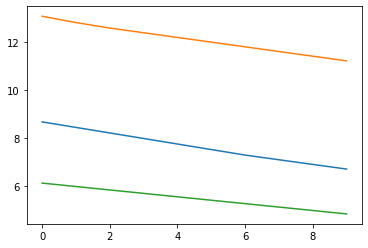

In [33]:

plt.plot(O_descending.T)